
# Preprocessing for MIT data (Binary classification) with MinMax Scaler and Oversamling
The default preprocessing step is what we conclude in our report. 
You can check below what should be input for this notebook and what would be the output if necessary.


Processing **steps** for MIT dataset:   
    resample: Oversampling  
    rescaling: MinMaxScaler  


**Input** : Cleaned data with dummy target variable.   
mitbih_test_clean.csv   
mitbih_train_clean.csv

**Output** : Sampled and Scaled data with dummy target:   
mitbih_binary_train_shift_minmax_oversampling.csv  
mitbih_binary_test_shift_minmax_oversampling.csv


### The following code processes raw data, aligns signals, handles class imbalance, scales features, and saves clean datasets.


In [2]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
import sys
import os
import matplotlib.pyplot as plt

# Detect environment and set paths
data_path = ''
data_output_path = ''
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    data_output_path = data_path
else:
    print("Running on local environment")
    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    data_output_path = '../data/processed/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [3]:
# File paths
RawFiles = {
    'test': os.path.join(data_path, 'mitbih_test_clean.csv'),
    'train': os.path.join(data_path, 'mitbih_train_clean.csv'),
}

OutputFiles = {
    'test': os.path.join(data_output_path, 'mitbih_binary_test_shift_minmax_oversampling.csv'),
    'train': os.path.join(data_output_path, 'mitbih_binary_train_shift_minmax_oversampling.csv'),
}


# Utility functions

In [4]:
def add_columns_to_dataframe(df):
    """Add column names to DataFrame."""
    num_columns = df.shape[1]
    feature_columns = [f'c_{i}' for i in range(num_columns - 1)]
    df.columns = feature_columns + ['target']
    return df

def convert_column_to_int(df, column):
    """Convert column to integers, handling NaN values."""
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df.dropna(subset=[column], inplace=True)
    df[column] = df[column].astype(int)
    return df

def find_r_peak(signal):
    """Find the R-peak (highest peak) in the signal."""
    peaks, _ = find_peaks(signal)
    if len(peaks) == 0:
        print("No R-peak found. Using midpoint for alignment.")  # Suggestion 2: Logging for missing R-peaks
        return len(signal) // 2
    return peaks[np.argmax(signal[peaks])]

def align_and_pad_signals(data, target_length=188):
    """Align signals based on R-peak and pad to target length."""
    aligned_data = []
    for _, row in data.iterrows():
        signal = row.values[:-1]
        r_peak = find_r_peak(signal)
        shift = target_length // 2 - r_peak
        shifted_signal = np.roll(signal, shift)
        padded_signal = np.pad(shifted_signal, (0, max(0, target_length - len(shifted_signal))), 'constant')[:target_length]
        aligned_data.append(padded_signal)
    return pd.DataFrame(aligned_data)

def plot_histograms_by_target(data, target_column, title, save_path=None):
    """Create histograms by target class with dynamic bin sizes."""
    classes = data[target_column].unique()
    
    plt.figure(figsize=(12, 8))
    for c in classes:
        class_data = data[data[target_column] == c].iloc[:, :-1].values.flatten()
        bin_count = min(100, len(class_data) // 10)  # Dynamic bin size based on class size
        plt.hist(class_data, bins=bin_count, alpha=0.5, label=f'Target {c}', density=True)
    
    plt.title(title)
    plt.xlabel("Value Range")
    plt.ylabel("Relative Frequency")
    plt.legend(title="Target Classes")
    plt.grid(axis='y', alpha=0.75)
    
    if save_path:  # Suggestion 5: Option to save plots
        plt.savefig(save_path)
        print(f"Histogram saved to: {save_path}")
    
    plt.show()

## Load data

In [5]:
# Load data
mitbih_train = pd.read_csv(RawFiles['train'], header=None)
mitbih_test = pd.read_csv(RawFiles['test'], header=None)

C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_20044\2432589112.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  mitbih_train = pd.read_csv(RawFiles['train'], header=None)
C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_20044\2432589112.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,

## Shift and Oversampling

In [6]:
# Add column names and preprocess
for df in [mitbih_train, mitbih_test]:
    add_columns_to_dataframe(df)
    convert_column_to_int(df, 'target')

# Map target classes
for df in [mitbih_train, mitbih_test]:
    df['target'] = df['target'].replace({'Normal': 0, 'abnormal': 1})

# Align and pad signals
aligned_train_data = align_and_pad_signals(mitbih_train)
aligned_test_data = align_and_pad_signals(mitbih_test)

# Add target column back
aligned_train_data['target'] = mitbih_train['target'].values
aligned_test_data['target'] = mitbih_test['target'].values

# Oversample training data
X_train = aligned_train_data.drop(columns=['target'])
y_train = aligned_train_data['target']
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


## Scaling

Histogram saved to: ../data/processed/train_histogram.png


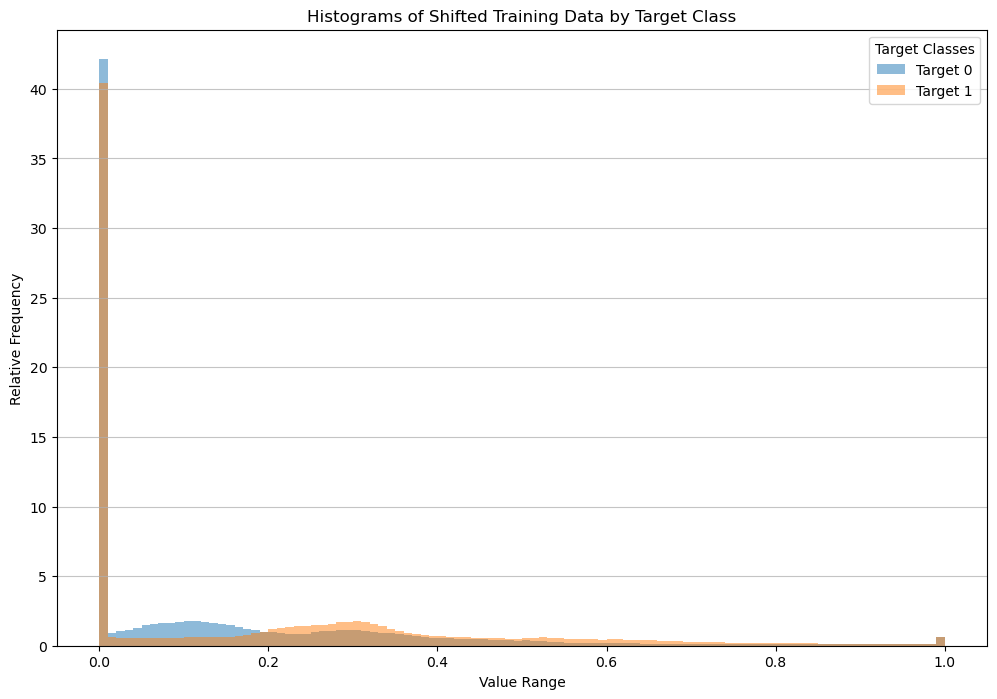

Histogram saved to: ../data/processed/test_histogram.png


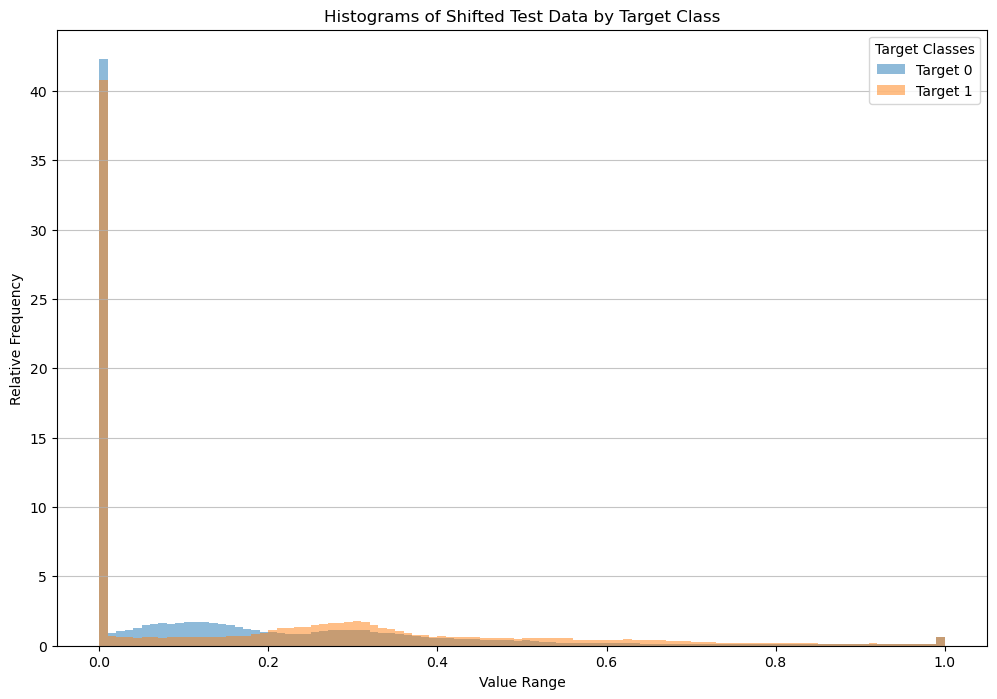

Data processing complete. Files saved!


In [7]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(aligned_test_data.drop(columns=['target']))

# Convert scaled data back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=[f'c_{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f'c_{i}' for i in range(X_test_scaled.shape[1])])
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['target'])
y_test_df = pd.DataFrame(aligned_test_data['target'], columns=['target'])

# Combine scaled features and targets
shifted_train_clean = pd.concat([X_train_scaled_df, y_train_resampled_df], axis=1)
shifted_test_clean = pd.concat([X_test_scaled_df, y_test_df.reset_index(drop=True)], axis=1)

# Save processed data
os.makedirs(data_output_path, exist_ok=True)
shifted_train_clean.to_csv(OutputFiles['train'], index=False)
shifted_test_clean.to_csv(OutputFiles['test'], index=False)

# Plot histograms for shifted training and test data
plot_histograms_by_target(
    shifted_train_clean, 'target', 
    "Histograms of Shifted Training Data by Target Class",
    save_path=os.path.join(data_output_path, "train_histogram.png")
)

plot_histograms_by_target(
    shifted_test_clean, 'target', 
    "Histograms of Shifted Test Data by Target Class",
    save_path=os.path.join(data_output_path, "test_histogram.png")
)

print("Data processing complete. Files saved!")

In [8]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-08 09:06:25.164995


# Source

https://www.nature.com/articles/s41598-021-97118-5#further-reading

https://www.youtube.com/watch?v=3tfin4sSBFQ

